# Experiment 5: Custom UNet Architecture

To have more control over the UNet, neuralprocesses has been forked. This will allow things like dropout/batchnorm to be added, potentially aiding performance.

## Model Training

For simplicity, we are assuming that a dataset is already available on disk.

In [46]:
import deepsensor.torch
from deepsensor.model.convnp import ConvNP

In [47]:
model = ConvNP(dim_x = 2, conv_arch="unet", dropout=0.0, unet_channels=[64, 128, 256])

In [48]:
model.model.decoder[0]

UNet(
  (before_turn_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(2, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): Dropout2d(p=0.0, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (2): Dropout2d(p=0.0, inplace=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (2): Dropout2d(p=0.0, inplace=False)
    )
  )
  (after_turn_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): Dropout2d(p=0.0, inplace=False)
    )
    (1): Sequential(
      (0): Upsample(scale_factor=2.0, mode='bilinear')
      (1): Conv2d(256, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (2): Dropout2d(p=0.0, inplace=False)
    )
    (2): Se

In [49]:
import deepsensor.torch
from deepsensor.data.loader import TaskLoader
from deepsensor.data.processor import DataProcessor
from deepsensor.model.convnp import ConvNP

import xarray as xr
import pandas as pd
import numpy as np

# Load raw data
ds_raw = xr.tutorial.open_dataset("air_temperature")["air"]
ds_raw2 = xr.tutorial.open_dataset("air_temperature")["air"]
ds_raw2.name = "air2"

# Normalise data
data_processor = DataProcessor(x1_name="lat", x2_name="lon")
ds = data_processor(ds_raw)
ds2 = data_processor(ds_raw2)

# Set up task loader
task_loader = TaskLoader(context=ds, target=[ds])

# Set up model
model = ConvNP(data_processor, task_loader, dropout=0.2)

# Predict on new task with 10% of context data and a dense grid of target points
test_tasks = task_loader(
    pd.date_range("2014-12-25", "2014-12-31"), context_sampling=40, target_sampling="all"
)
# print(repr(test_tasks))

X_t = ds_raw
pred = model.predict(test_tasks, X_t=X_t, n_samples=5)
print(pred)

X_t = np.zeros((2, 1))
pred = model.predict(test_tasks, X_t=X_t, X_t_is_normalised=True)

task_for_testing = test_tasks[0].add_batch_dim()

loss = model.loss_fn(task_for_testing, edge_margin=0.1)

print(pred)

print(f"Loss = {loss.item()}")

# DEBUG
# task = task_loader("2014-12-31", context_sampling=40, target_sampling="all")
# samples = model.ar_sample(task, 5, ar_subsample_factor=20)

dim_yc inferred from TaskLoader: (1,)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 52
encoder_scales inferred from TaskLoader: [0.009615384042263031]
decoder_scale inferred from TaskLoader: 0.019230769230769232
Prediction({'air': ['mean', 'std', 'sample_0', 'sample_1', 'sample_2', 'sample_3', 'sample_4']}), mode=on-grid


AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
print(task_for_testing)

time: 2014-12-25 00:00:00
ops: ['batch_dim']
X_c: [(1, 2, 40)]
Y_c: [(1, 1, 40)]
X_t: [((1, 1, 25), (1, 1, 53))]
Y_t: [(1, 1, 25, 53)]



In [ ]:
import pickle

In [ ]:
from convcnp_assim_nz.learning.model_training import concat_tasks_custom, subsample_targets

test_task_path = "/esi/project/niwa00004/crowelenn/data/pickle/exp4_multiyear_reduced_channels/experiment4_nzra_target_train_tasks/0_0.pkl"
test_task_path_2 = "/esi/project/niwa00004/crowelenn/data/pickle/exp4_multiyear_reduced_channels/experiment4_nzra_target_train_tasks/1_0.pkl"
with open(test_task_path, 'rb') as f:
    test_task = pickle.load(f)
    X_t_new, Y_t_new, Y_t_aux_new = subsample_targets(test_task['X_t'], test_task['Y_t'], test_task['Y_t_aux'], 1000, seed=1, replace=False)
    test_task['X_t'] = X_t_new
    test_task['Y_t'] = Y_t_new
    test_task['Y_t_aux'] = Y_t_aux_new

with open(test_task_path_2, 'rb') as f:
    test_task_2 = pickle.load(f)
    X_t_new, Y_t_new, Y_t_aux_new = subsample_targets(test_task_2['X_t'], test_task_2['Y_t'], test_task_2['Y_t_aux'], 1000, seed=2, replace=False)
    test_task_2['X_t'] = X_t_new
    test_task_2['Y_t'] = Y_t_new
    test_task_2['Y_t_aux'] = Y_t_aux_new

test_task_joined = concat_tasks_custom([test_task, test_task_2])

print(test_task_joined)

xt = test_task_joined['X_t']
yt = test_task_joined['Y_t']

X_t_new, Y_t_new, Y_t_aux_new = model.remove_edge_targets(xt, yt, None, margin=0.1)

#test_task_joined['X_t'] = X_t_new
#test_task_joined['Y_t'] = Y_t_new
#test_task_joined['Y_t_aux'] = Y_t_aux_new

time: [Timestamp('2013-01-02 00:00:00'), Timestamp('2013-01-02 01:00:00')]
ops: ['batch_dim', 'float32', 'numpy_mask', 'nps_mask']
X_c: [(2, 2, 181), ((2, 1, 61), (2, 1, 61)), ((2, 1, 556), (2, 1, 556))]
Y_c: [<neuralprocesses.mask.Masked object at 0x14abe1abed50>, <neuralprocesses.mask.Masked object at 0x14abe1abf650>, <neuralprocesses.mask.Masked object at 0x14abe1f538b0>]
X_t: [(2, 2, 1000)]
Y_t: [(2, 1, 1000)]
Y_t_aux: (2, 2, 1000)



Before: X_t (2, 1234321) Y_t (1, 1234321)
After: X_t (2, 790321) Y_t (1, 790321)
Before: X_t (2, 1234321) Y_t (1, 1234321)
After: X_t (2, 790321) Y_t (1, 790321)


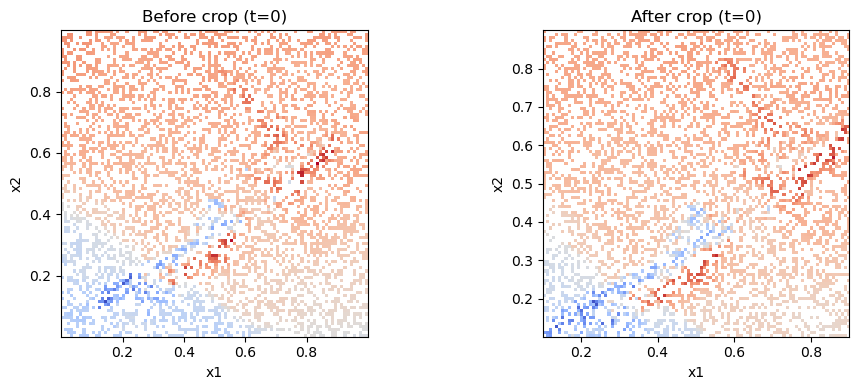

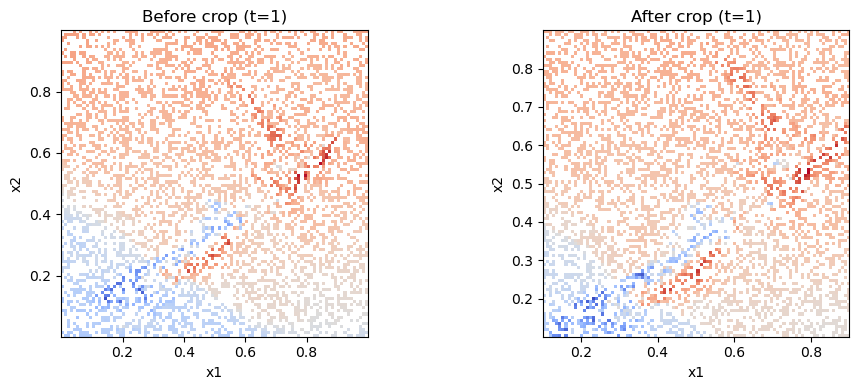

In [105]:
import numpy as np
import matplotlib.pyplot as plt


def _points_to_grid(x, y, v, bins=100):
    x = np.asarray(x)
    y = np.asarray(y)
    v = np.asarray(v)

    x_min, x_max = np.nanmin(x), np.nanmax(x)
    y_min, y_max = np.nanmin(y), np.nanmax(y)
    if x_min == x_max:
        x_min -= 0.5
        x_max += 0.5
    if y_min == y_max:
        y_min -= 0.5
        y_max += 0.5

    x_edges = np.linspace(x_min, x_max, bins + 1)
    y_edges = np.linspace(y_min, y_max, bins + 1)

    sum_grid, _, _ = np.histogram2d(y, x, bins=[y_edges, x_edges], weights=v)
    cnt_grid, _, _ = np.histogram2d(y, x, bins=[y_edges, x_edges])

    with np.errstate(invalid="ignore", divide="ignore"):
        img = sum_grid / cnt_grid
    img[cnt_grid == 0] = np.nan

    extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]
    return img, extent


def plot_crop_before_after(X_t_before, Y_t_before, X_t_after, Y_t_after, t_index=0, channel=0, max_points=5000, seed=0):
    """Visualize target locations before/after cropping for a single time index."""
    rng = np.random.default_rng(seed)

    Xb = X_t_before[0][t_index]
    Yb = Y_t_before[0][t_index]
    Xa = X_t_after[0][t_index]
    Ya = Y_t_after[0][t_index]

    x1b, x2b = Xb
    x1a, x2a = Xa

    # Build images for plotting
    if Yb.ndim == 3:
        x1v = x1b.squeeze()
        x2v = x2b.squeeze()
        yb_img = Yb[channel]
        extent_b = [x1v.min(), x1v.max(), x2v.min(), x2v.max()]
    else:
        xb = np.vstack([x1b.squeeze(), x2b.squeeze()])
        yb_vals = Yb[channel] if Yb.ndim == 2 else Yb
        if xb.shape[1] > max_points:
            idx = rng.choice(xb.shape[1], size=max_points, replace=False)
            xb_plot = xb[:, idx]
            yb_plot = yb_vals[idx]
        else:
            xb_plot = xb
            yb_plot = yb_vals
        yb_img, extent_b = _points_to_grid(xb_plot[0], xb_plot[1], yb_plot)

    if Ya.ndim == 3:
        x1v = x1a.squeeze()
        x2v = x2a.squeeze()
        ya_img = Ya[channel]
        extent_a = [x1v.min(), x1v.max(), x2v.min(), x2v.max()]
    else:
        xa = np.vstack([x1a.squeeze(), x2a.squeeze()])
        ya_vals = Ya[channel] if Ya.ndim == 2 else Ya
        if xa.shape[1] > max_points:
            idx = rng.choice(xa.shape[1], size=max_points, replace=False)
            xa_plot = xa[:, idx]
            ya_plot = ya_vals[idx]
        else:
            xa_plot = xa
            ya_plot = ya_vals
        ya_img, extent_a = _points_to_grid(xa_plot[0], xa_plot[1], ya_plot)

    # Shared colour scale based on Y values
    all_vals = np.concatenate([yb_img.ravel(), ya_img.ravel()])
    vmin = np.nanmin(all_vals)
    vmax = np.nanmax(all_vals)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False)

    axes[0].imshow(yb_img, origin="lower", cmap="coolwarm", vmin=vmin, vmax=vmax, extent=extent_b, aspect="auto")
    axes[0].set_title(f"Before crop (t={t_index})")

    axes[1].imshow(ya_img, origin="lower", cmap="coolwarm", vmin=vmin, vmax=vmax, extent=extent_a, aspect="auto")
    axes[1].set_title(f"After crop (t={t_index})")

    for ax in axes:
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_aspect("equal", adjustable="box")

    plt.tight_layout()

    print("Before:", "X_t", Xb.shape, "Y_t", Yb.shape)
    print("After:", "X_t", Xa.shape, "Y_t", Ya.shape)


    # Example usage with existing variables
plot_crop_before_after(xt, yt, X_t_new, Y_t_new, t_index=0, channel=0)
plot_crop_before_after(xt, yt, X_t_new, Y_t_new, t_index=1, channel=0)